In [1]:
import cv2
import numpy as np
import math 
import matplotlib.pyplot as plt
from skimage import data
import skimage
from skimage.color import rgb2hed, hed2rgb, label2rgb


In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

## 6.1  Upscaling :

We do **nearest neighbour interpolation** since each value in the label map represents some component and is an integer. Thus its not desirable to produce new value and thus any other form of interpolation like linear or cubic can't be performed.
Even forward mapping is not desirable as some part of image will have black pixels which are not real.


#### Steps

1. Create a new image with new scaled dimensions filled with zeros.
2. Do **backward mapping** for each pixel of new image by multiplying a pixel location with the affine matrix of the transformation.

<img src="../images/6.1.jpeg" alt="Drawing" style="width: 700px;"/>
<img src="../images/6.1.1.jpeg" alt="Drawing" style="width: 700px;"/>

In [3]:

def upscale(img1,k,img2):
    m = img1.shape[0]
    n = img1.shape[1]
    
    h = int(k*m)
    w = int(img2*n)

    resized=np.empty([h,w])
    r_x = 0
    r_y = 0
    if w>1 :
        r_x=float(n-1)/(w-1) 
    if h>1 :
        r_y=float(m-1)/(h-1) 

    for i in range(h):
        for j in range(int(w)):
            x_l = int(r_x*j)
            y_l = int(r_y*i)
            x_h = math.ceil(r_x*j)
            y_h = math.ceil(r_y*i)
            
            x_weight = (r_x*j)-x_l
            y_weight = (r_y*i)-y_l
    
            resized[i][j] = img1[y_l, x_l]*(1-x_weight)*(1-y_weight)+img1[y_l, x_h]*x_weight*(1-y_weight)+img1[y_h, x_l]*y_weight*(1-x_weight)+img1[y_h, x_h]*x_weight*y_weight
    return resized.astype(np.uint8)

def upscale_rgb(img,k,img2):
    res = []
    for i in range(3):
        res.append(upscale(img[:,:,i],k,img2))  
    img_res = np.stack([res[0],res[1],res[2]],axis=2)   
    return img_res

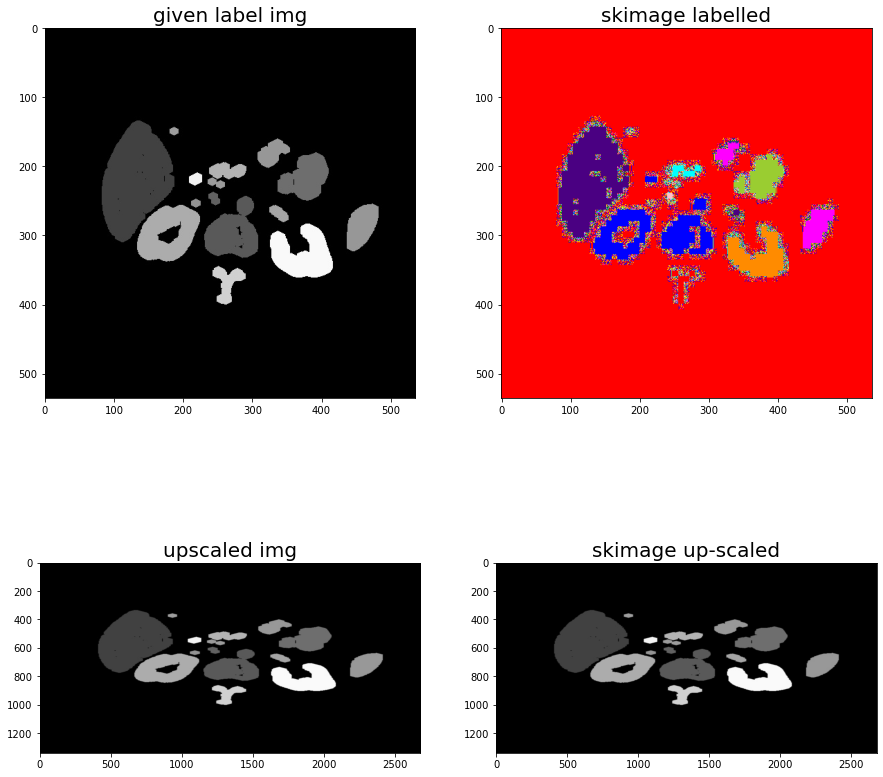

In [4]:
images = []
titles = []

img=cv2.imread('./../images/labelled.jpg',0)
orig_img=label2rgb(img,image=None,colors=None,bg_color=(0,0,0),alpha=0.2,bg_label=-1,kind='overlay')

images.append(img)
titles.append('given label img')
images.append(orig_img)
titles.append('skimage labelled')

upscaled_img=upscale(np.copy(img),2.5,5)

up_sk=label2rgb(upscaled_img,image=None,colors=None,bg_color=(0,0,0),alpha=0.2,bg_label=-1,kind='overlay')


images.append(upscaled_img)
titles.append('upscaled img')
images.append(upscaled_img)
titles.append('skimage up-scaled')
display_img_arr(images,2, 2, (15, 15), titles)

## 6.2  Rotation :

We should perform **nearest neighbour interpolation**  for above mentioned reasons.


#### Steps
1. Translate the image to the center
1. Perform rotation  by using matrix of $\cos{\theta}$ and $\sin{\theta}$. 
1. Translate back to 0,0

<img src="../images/6.2.jpeg" alt="Drawing" style="width: 700px;"/>


In [5]:
def fitImage(img):
    m = img.shape[0]
    n = img.shape[1]
    for i in range(n, 0, -1):
        if max(img[0:m,i-1:i]):
            xmax = i
            break
    for i in range(n):
        if max(img[0:m,i:i+1]):
            xmin = i
            break
    for i in range(m-1, 0, -1):
        if max(img[i]):
            ymax = i
            break
    for i in range(m):
        if max(img[i]):
            ymin = i
            break
    res = img[ymin:ymax, xmin:xmax]
    return res

def Retain(image, A):
    m = image.shape[0]
    n = image.shape[1]
    res = np.zeros(image.shape)
    A = -A
    for i in range(m):
        for j in range(n):
            x = int((i - int(m/2))*np.cos(np.radians(A))- (j - int(n/2))*np.sin(np.radians(A)) + int(m/2))
            if (x<0 or x>=m):
                continue
            y = int((i - int(m/2))*np.sin(np.radians(A)) + (j - int(n/2))*np.cos(np.radians(A)) + int(n/2))
            if(y<0 or y>=n):
                continue
            
            res[i][j]=image[x][y] 
    return res

def noRetain(image, A):
    A = -A
    C = int(max(image.shape)/2)
    im = np.zeros((2*max(image.shape), 2*max(image.shape)))
    im[C:C+image.shape[0], C:C+image.shape[1]] = image
    
    m = im.shape[0]
    n = im.shape[1]
    res = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            x = int((i - int(m/2))*np.cos(np.radians(A)) - (j - int(n/2))*np.sin(np.radians(A)) + int(m/2))
            if (x<0 or x>=m):
                continue
            y = int((i - int(m/2))*np.sin(np.radians(A)) + (j - int(n/2))*np.cos(np.radians(A)) + int(n/2))
            if( y<0 or y>=n):
                continue   
            res[i][j]=im[x][y] 
    return fitImage(res)

def rotateImage(image, angle, retain):
    if retain:
        res =  Retain(image, angle)
    else:
        res =  noRetain(image, angle)
    return res.astype(np.uint8)

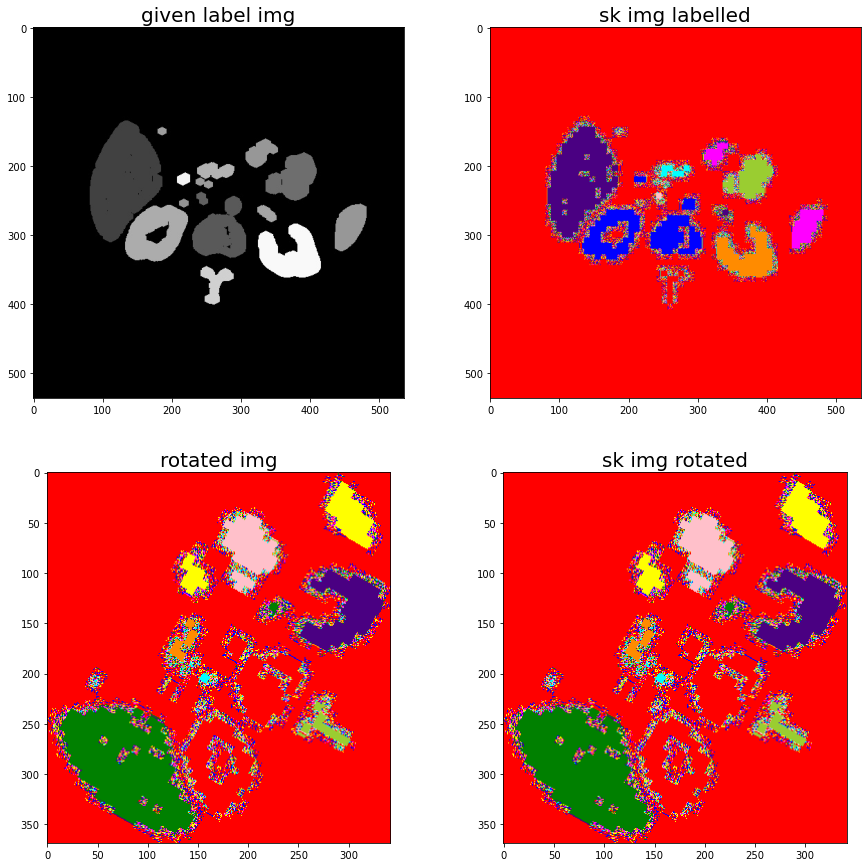

In [6]:
images = []
titles = []

img=cv2.imread('./../images/labelled.jpg',0)
img_sk=label2rgb(img,image=None,colors=None,bg_color=(0,0,0),alpha=0.2,bg_label=-1,kind='overlay')

images.append(img)
titles.append('given label img')

images.append(img_sk)
titles.append('sk img labelled')

rotated_img=rotateImage(np.copy(img),60,0)
rotated_img=label2rgb(rotated_img,image=None,colors=None,bg_color=(0,0,0),alpha=0.2,bg_label=-1,kind='overlay')

images.append(rotated_img)
titles.append('rotated img')
images.append(rotated_img)
titles.append('sk img rotated')

display_img_arr(images,2, 2, (15, 15), titles)